# Graph Convolution Networks

In this notebook, we will implement an Graph Convolution Network (GCN) which predicts LogS and LogP of molecules in ESOL dataset.

## Setting up the notebook and importing the necessary libraries

In [ ]:
!pip install RdKit
!pip install torch_geometric

In [4]:
seed = 42

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from io import StringIO


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.optim import Adam
from torch.nn import Linear, Parameter
from torch.utils.data import random_split
from torch.nn import Sequential as Seq, Linear, ReLU
torch.cuda.manual_seed(seed) # Sets seed for current GPU
from tqdm import tqdm


import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors
from rdkit.Chem.rdchem import BondType

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import knn_graph

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



## Loading the dataset

In [5]:
def load_esol_dataset():
    url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
    response = requests.get(url)
    response.raise_for_status()

    df = pd.read_csv(StringIO(response.text))
    print(f"Loaded ESOL with {len(df)} compounds")
    print("Columns in dataset:", df.columns.tolist())
    # Use 'smiles' and 'measured log solubility in mols per litre'
    df = df[['smiles', 'measured log solubility in mols per litre','ESOL predicted log solubility in mols per litre']]
    df.columns = ['SMILES', 'LogS','ESol_Predicted_LogS']

    # Remove invalid SMILES
    valid_smiles = []
    for smiles in df['SMILES']:
        mol = Chem.MolFromSmiles(smiles)
        valid_smiles.append(mol is not None)

    df = df[valid_smiles].reset_index(drop=True)

    return df

# Load dataset
df = load_esol_dataset()

Loaded ESOL with 1128 compounds
Columns in dataset: ['Compound ID', 'ESOL predicted log solubility in mols per litre', 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area', 'measured log solubility in mols per litre', 'smiles']


### Visualizing the distribution of the labels in the dataset

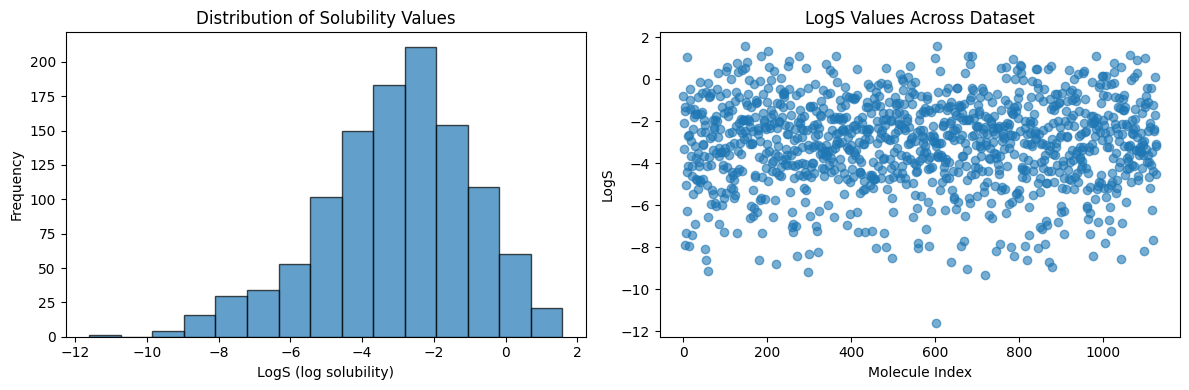

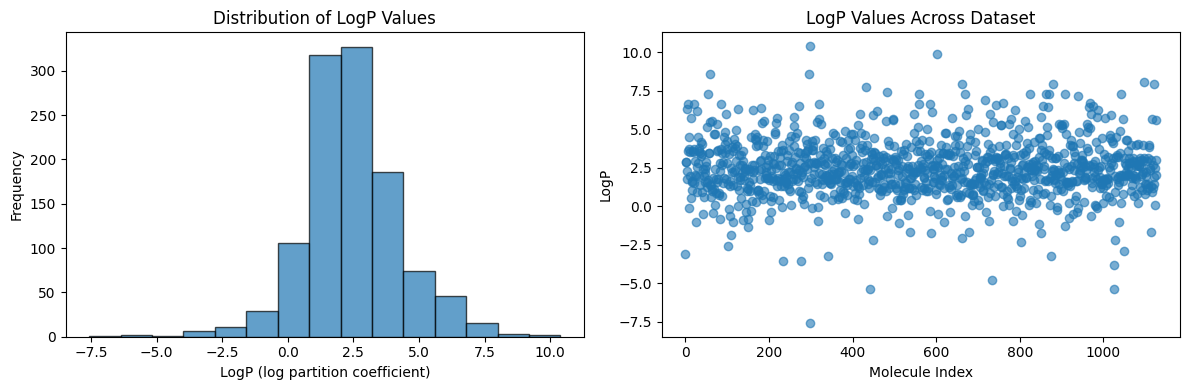

In [6]:
# logS distribution plots

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogS'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogS (log solubility)')
plt.ylabel('Frequency')
plt.title('Distribution of Solubility Values')

plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogS'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogS')
plt.title('LogS Values Across Dataset')
plt.tight_layout()
plt.show()

# logP distribution plots

LogP =[]
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        logp = Crippen.MolLogP(mol)
        LogP.append(logp)
    else:
        LogP.append(np.nan)
df['LogP'] = LogP


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['LogP'], bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('LogP (log partition coefficient)')
plt.ylabel('Frequency')
plt.title('Distribution of LogP Values')
plt.subplot(1, 2, 2)
plt.scatter(range(len(df)), df['LogP'], alpha=0.6)
plt.xlabel('Molecule Index')
plt.ylabel('LogP')
plt.title('LogP Values Across Dataset')
plt.tight_layout()

### Normalizing the target labels (logS and logP)

Here, we normalize the logS and logP labels and then, visualize the normalized values on a plot.

In [7]:
scaler_logS = StandardScaler()
df['logS_scaled'] = scaler_logS.fit_transform(df[['LogS']])
scaler_logP = StandardScaler()
df['logP_scaled'] = scaler_logP.fit_transform(df[['LogP']])

## Data Preprocessing and Preparing the dataset

Helper functions to convert atoms to nodes

In [8]:
COMMON_ATOMS =set() #Atomic numbers of all atoms in dataset
for smile in df["SMILES"]:
    mol = Chem.MolFromSmiles(smile)
    for atom in mol.GetAtoms():
        COMMON_ATOMS.add(atom.GetAtomicNum())
COMMON_ATOMS.add(1) #Hydrogen is not explicitly present in mol.GetAtoms()
COMMON_ATOMS = sorted(list(COMMON_ATOMS))

def one_hot_atomic_number(atomic_num):
    idx = COMMON_ATOMS.index(atomic_num) if atomic_num in COMMON_ATOMS else len(COMMON_ATOMS)
    return F.one_hot(torch.tensor(idx), num_classes=len(COMMON_ATOMS) + 1).float()

def atom_features(atom):
    features = torch.cat([
        one_hot_atomic_number(atom.GetAtomicNum()),  # one-hot atomic number
        torch.tensor([
            atom.GetDegree(),
            atom.GetFormalCharge(),
            atom.GetHybridization().real,
            atom.GetIsAromatic()
        ], dtype=torch.float)
    ])
    return features

Helper functions to convert bonds to edges in the graph

In [9]:
BOND_TYPES = [
    BondType.SINGLE,
    BondType.DOUBLE,
    BondType.TRIPLE,
    BondType.AROMATIC
]

def one_hot_bond_type(bond_type):
    idx = BOND_TYPES.index(bond_type) if bond_type in BOND_TYPES else len(BOND_TYPES)
    return F.one_hot(torch.tensor(idx), num_classes=len(BOND_TYPES) + 1).float()

def bond_features(bond):
    features = torch.cat([
        one_hot_bond_type(bond.GetBondType()),  # one-hot bond type
        torch.tensor([
            bond.GetIsConjugated(),
            bond.IsInRing()
        ], dtype=torch.float)
    ])
    return features

Converting the SMILES strings into graphs.

In [10]:
def smiles_to_data(smiles, y):

    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Node features
    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    # Edge features and connectivity
    edge_index = []
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        f = bond_features(bond)
        edge_index += [[i, j], [j, i]]
        edge_attr += [f, f]

    if not edge_attr:
      return None
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr)

    y = torch.tensor([y], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

def prepare_dataset(df):
    data_list = []
    for _, row in df.iterrows():
        data = smiles_to_data(row['SMILES'], [row['logS_scaled'], row['logP_scaled']])
        if data:  # Skip invalid SMILES
            data_list.append(data)
    return data_list


Preparing the dataset and making PyTorch dataloaders

In [11]:
data_list = prepare_dataset(df)

loader = DataLoader(data_list, batch_size=32, shuffle=True)
train_set,test_set = random_split(data_list,[0.8 , 0.2])
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=True)

## Defining the hyperparameters and the model


In [12]:
NUM_EPOCHS = 100
BATCH_SIZE = 8 
LEARNING_RATE = 0.001
DROPOUT = 0.2
hidden_channels = 64
PATIENCE = 10  # Early stopping patience
min_delta = 0.001  # Minimum change to qualify as an improvement

GCN computation can be divided into 2 phases - Message Passing phase and Update phase.

During message passing phase,information from other neighbouring nodes is passed to node. It is defined as : 

$$m_i = \sum_{j=1}^{N(i)} M_t(h_i^t,h_j^t,e_{ij})$$

where $m_i$ is message passed to node i, $M_t$ is message function, $h_i^t$ and $h_j^t$ are hidden states of nodes i and j respectively, and $e_{ij}$ is edge between nodes i and j and N(i) is set of neighbours of node i.

During update phase, hidden state of node i is updated as :

$$h_i^{t+1} = U_t(m_i,h_i^t)$$

where $U_t$ is update function.


### GCN Layer

First, we will implement a GCN layer using MPNN framework.

The GCN layer is defined as follows:

$$\mathbf{x}_i^{(k)} = \sum_{j \in \mathcal{N}(i) \cup \{i\}} \frac{1}{\sqrt{\deg(i)} \cdot \sqrt{\deg(j)}} \cdot \left(\mathbf{W}^\top \cdot \mathbf{x}_j^{(k-1)}\right) + \mathbf{b},$$

In [13]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation.
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index,edge_attr):

        # Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Linearly transform node feature matrix.
        x = self.lin(x)

        # Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        #  Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm,edge_attr=edge_attr)

        # Apply a final bias vector.
        out = out + self.bias

        return out

    def message(self, x_j, norm):
        #  Normalize node features.
        return norm.view(-1, 1) * x_j

Model using GCN layers:

In [14]:
class GCN(nn.Module):
    def __init__(self, num_node_features=15, num_edge_features=7, hidden_channels=64):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(num_node_features, hidden_channels)

        
        self.conv2 = GCNConv(hidden_channels, 32)
        # Fully connected layers for regression
        self.fc1 = nn.Linear(32, 64)
        self.dropout = nn.Dropout(0.2)
        self.out = nn.Linear(64, 2)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = F.relu(self.conv1(x, edge_index,edge_attr))  # (N_nodes, 64)
        x = F.relu(self.conv2(x, edge_index,edge_attr))  # (N_nodes, 32)
        x = global_add_pool(x, batch)                     # (batch_size, 32)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.out(x)                                # (batch_size, 1)

## Training and evaluating the model

In [15]:
def train_model(model, train_loader, test_loader,criterion,device,num_epochs = NUM_EPOCHS,
                lr=LEARNING_RATE,patience = PATIENCE, min_delta = min_delta):
    optimizer = Adam(model.parameters(), lr=lr)
    model.to(device)
    train_losses=[]
    train_losses_logs = []
    train_losses_logp = []
    test_losses=[]
    test_losses_logs = []
    test_losses_logp = []
    min_test_loss = float('inf')  # Initialize to a large value
    epochs_without_improvement = 0
    best_epoch = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loss_logs = 0
        train_loss_logp = 0
        for batch in tqdm(train_loader,desc = 'training set'):
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss_logs = criterion(pred[:, 0], batch.y[:, 0])  # LogS loss
            loss_logp = criterion(pred[:, 1], batch.y[:, 1])  # LogP loss
            loss = loss_logs + loss_logp
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_loss_logs += loss_logs.item()
            train_loss_logp += loss_logp.item()
        print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader):.4f} | LogS Loss: {train_loss_logs / len(train_loader):.4f} | LogP Loss: {train_loss_logp / len(train_loader):.4f}")
        train_losses_logs.append(train_loss_logs / len(train_loader))
        train_losses_logp.append(train_loss_logp / len(train_loader))
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        test_loss = 0
        test_loss_logs = 0
        test_loss_logp = 0
        with torch.no_grad():
            for batch in tqdm(test_loader,desc = 'testing set'):
                batch = batch.to(device)
                pred = model(batch)
                loss_logs = criterion(pred[:, 0], batch.y[:, 0]) # LogS loss
                loss_logp = criterion(pred[:, 1], batch.y[:, 1]) # LogP loss
                loss = loss_logs + loss_logp
                test_loss_logs += loss_logs.item()
                test_loss_logp += loss_logp.item()
                test_loss += loss.item()
        print(f"Epoch {epoch+1}, Test Loss: {test_loss / len(test_loader):.4f} | LogS Loss: {test_loss_logs / len(test_loader):.4f} | LogP Loss: {test_loss_logp / len(test_loader):.4f}")
        test_losses.append(test_loss / len(test_loader))
        test_losses_logs.append(test_loss_logs / len(test_loader))
        test_losses_logp.append(test_loss_logp / len(test_loader))
        if((test_loss / len(test_loader)) < min_test_loss - min_delta):
            min_test_loss = (test_loss / len(test_loader))
            epochs_without_improvement =0
            best_epoch = epoch
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > patience:
                print(f"Early stopping at epoch {epoch+1} with best epoch {best_epoch+1}")
                break
        
    return train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp

Plot training results

In [16]:
def plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot comparison of all losses
    plt.plot(epochs, train_losses, 'b-', label='Total Train', linewidth=2)
    plt.plot(epochs, test_losses, 'r-', label='Total Test', linewidth=2)
    plt.plot(epochs, train_losses_logs, 'b--', label='Train LogS', alpha=0.7)
    plt.plot(epochs, test_losses_logs, 'r--', label='Test LogS', alpha=0.7)
    plt.plot(epochs, train_losses_logp, 'b:', label='Train LogP', alpha=0.7)
    plt.plot(epochs, test_losses_logp, 'r:', label='Test LogP', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss vs Epochs')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Function to evaluate the model

In [17]:
def evaluate_model(model, test_loader, device, scaler_logS=None, scaler_logP=None):

    # Load the best model
    model.to(device)
    model.eval()
    
    # Collect predictions and actual values
    preds_logs = []
    preds_logp = []
    actual_logs = []
    actual_logp = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='Evaluating model'):
            batch = batch.to(device)
            pred = model(batch)
            
            pred_logs_batch = pred[:, 0].cpu().numpy()
            pred_logp_batch = pred[:, 1].cpu().numpy()
            actual_logs_batch = batch.y[:, 0].cpu().numpy()
            actual_logp_batch = batch.y[:, 1].cpu().numpy()
            
            preds_logs.extend(pred_logs_batch)
            preds_logp.extend(pred_logp_batch)
            actual_logs.extend(actual_logs_batch)
            actual_logp.extend(actual_logp_batch)
    
    # Convert to numpy arrays
    preds_logs = np.array(preds_logs)
    preds_logp = np.array(preds_logp)
    actual_logs = np.array(actual_logs)
    actual_logp = np.array(actual_logp)

    # Inverse transform if scalers are provided
    if scaler_logS is not None:
        preds_logs = scaler_logS.inverse_transform(preds_logs.reshape(-1, 1)).flatten()
        actual_logs = scaler_logS.inverse_transform(actual_logs.reshape(-1, 1)).flatten()
    
    if scaler_logP is not None:
        preds_logp = scaler_logP.inverse_transform(preds_logp.reshape(-1, 1)).flatten()
        actual_logp = scaler_logP.inverse_transform(actual_logp.reshape(-1, 1)).flatten()
    
    # Calculate metrics for LogS
    mse_logs = mean_squared_error(actual_logs, preds_logs)
    mae_logs = mean_absolute_error(actual_logs, preds_logs)
    r2_logs = r2_score(actual_logs, preds_logs)
    rmse_logs = np.sqrt(mse_logs)
    
    # Calculate metrics for LogP
    mse_logp = mean_squared_error(actual_logp, preds_logp)
    mae_logp = mean_absolute_error(actual_logp, preds_logp)
    r2_logp = r2_score(actual_logp, preds_logp)
    rmse_logp = np.sqrt(mse_logp)
    
    
    
    print("LogS PREDICTION METRICS:")
    print(f"  MSE:  {mse_logs:.4f}")
    print(f"  RMSE: {rmse_logs:.4f}")
    print(f"  MAE:  {mae_logs:.4f}")
    print(f"  R²:   {r2_logs:.4f}")
    print()
    
    print("LogP PREDICTION METRICS:")
    print(f"  MSE:  {mse_logp:.4f}")
    print(f"  RMSE: {rmse_logp:.4f}")
    print(f"  MAE:  {mae_logp:.4f}")
    print(f"  R²:   {r2_logp:.4f}")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(1, 2, figsize=(18, 12))
    
    # Plot 1: LogS True vs Predicted
    axes[0].scatter(actual_logs, preds_logs, alpha=0.6, color='blue', s=20)
    min_val = min(min(actual_logs), min(preds_logs))
    max_val = max(max(actual_logs), max(preds_logs))
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('True LogS')
    axes[0].set_ylabel('Predicted LogS')
    axes[0].set_title(f'LogS: True vs Predicted (R² = {r2_logs:.3f})')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].scatter(actual_logp, preds_logp, alpha=0.6, color='green', s=20)
    min_val = min(min(actual_logp), min(preds_logp))
    max_val = max(max(actual_logp), max(preds_logp))
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[1].set_xlabel('True LogP')
    axes[1].set_ylabel('Predicted LogP')
    axes[1].set_title(f'LogP: True vs Predicted (R² = {r2_logp:.3f})')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

    return {
        "mae_logs": mae_logs,
        "mae_logp": mae_logp,
        "r2 logs": r2_logs,
        "r2 logp": r2_logp}   

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(num_node_features=data_list[0].x.shape[1], num_edge_features=data_list[0].edge_attr.shape[1], hidden_channels=hidden_channels).to(device)

train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp = train_model(
    model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=MSELoss(),
    device=device,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE,
    patience=PATIENCE,
    min_delta=min_delta
)

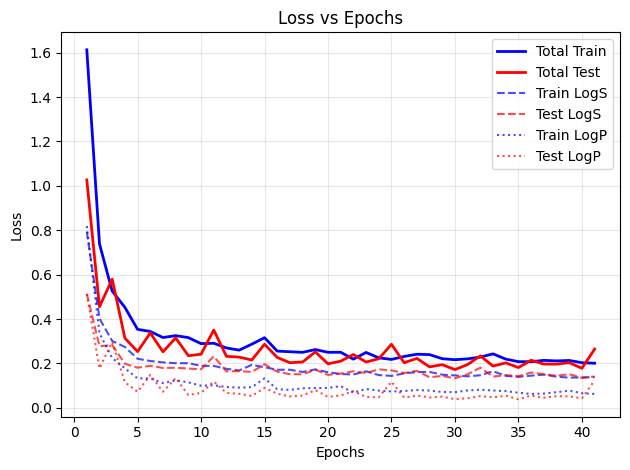

Evaluating model: 100%|██████████| 225/225 [00:00<00:00, 314.29it/s]


LogS PREDICTION METRICS:
  MSE:  0.6212
  RMSE: 0.7881
  MAE:  0.5937
  R²:   0.8501

LogP PREDICTION METRICS:
  MSE:  0.4237
  RMSE: 0.6509
  MAE:  0.4385
  R²:   0.8711


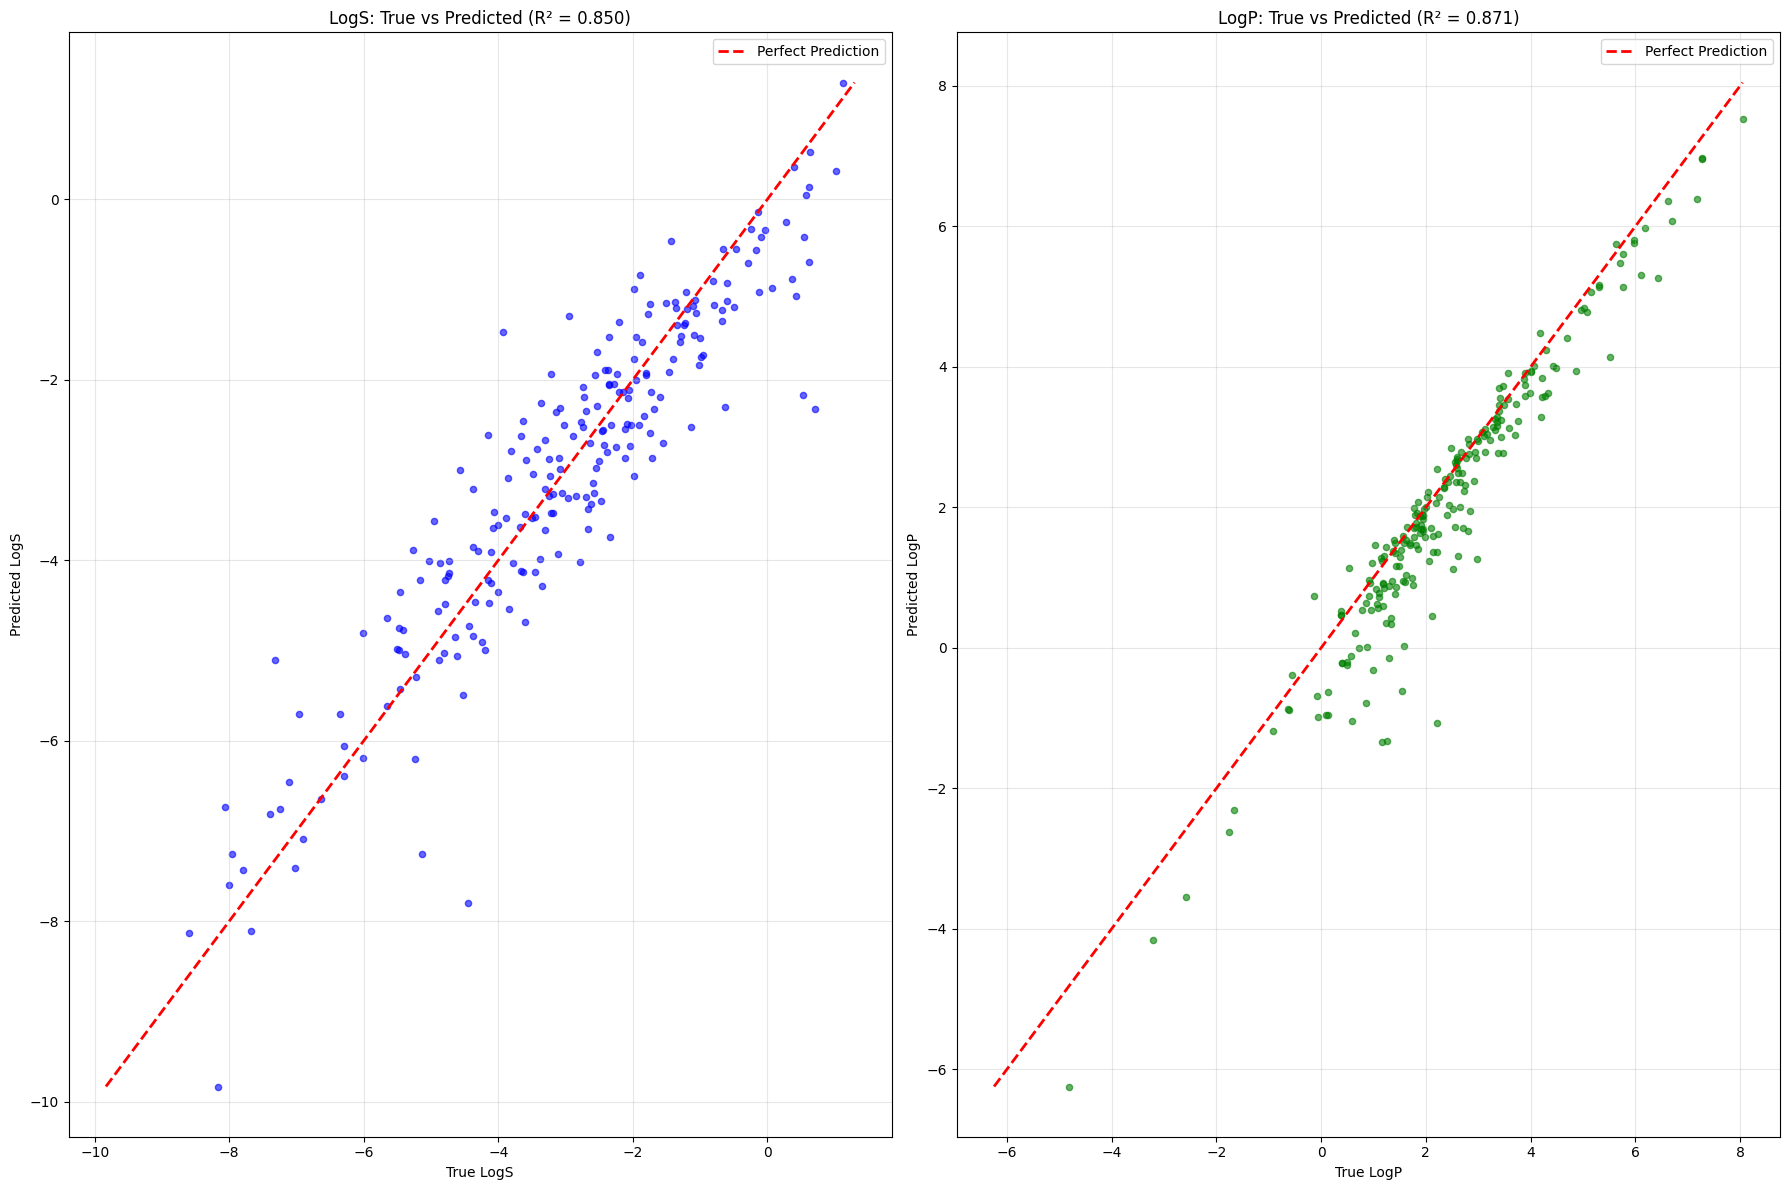

{'mae_logs': 0.5937278866767883,
 'mae_logp': 0.43854013085365295,
 'r2 logs': 0.850110650062561,
 'r2 logp': 0.8711124658584595}

In [19]:
plot_training_results(train_losses, train_losses_logs, train_losses_logp, test_losses, test_losses_logs, test_losses_logp)
evaluate_model(
    model,
    test_loader=test_loader,
    device=device,
    scaler_logS=scaler_logS,
    scaler_logP=scaler_logP
)